In [2]:
import os
import tensorflow as tf
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68606236/68606236 [==============================] - 3s 0us/step


In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [6]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


Found 1000 files belonging to 2 classes.


In [7]:
valdation_batches = tf.data.experimental.cardinality(validation_dataset)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
test_batches = valdation_batches // 5
test_dataset = validation_dataset.take(test_batches)
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
validation_dataset = validation_dataset.skip(test_batches)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of validation batches: 32
Number of test batches: 6
Number of validation batches: 26


In [8]:
class_names = train_dataset.class_names
class_names

['cats', 'dogs']

In [9]:
import numpy as np
import matplotlib.pyplot as plt

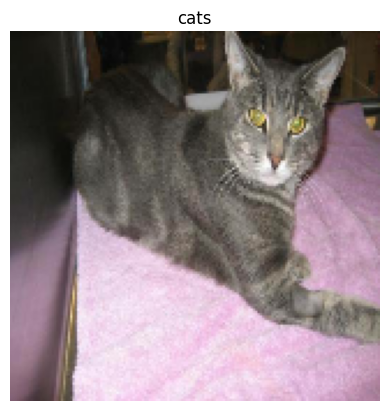

In [10]:
for image, label in train_dataset.take(1):
    image = image.numpy().astype("uint8")
    plt.imshow(image[0])
    plt.title(class_names[label[0]])
    plt.axis('off')
    plt.show()

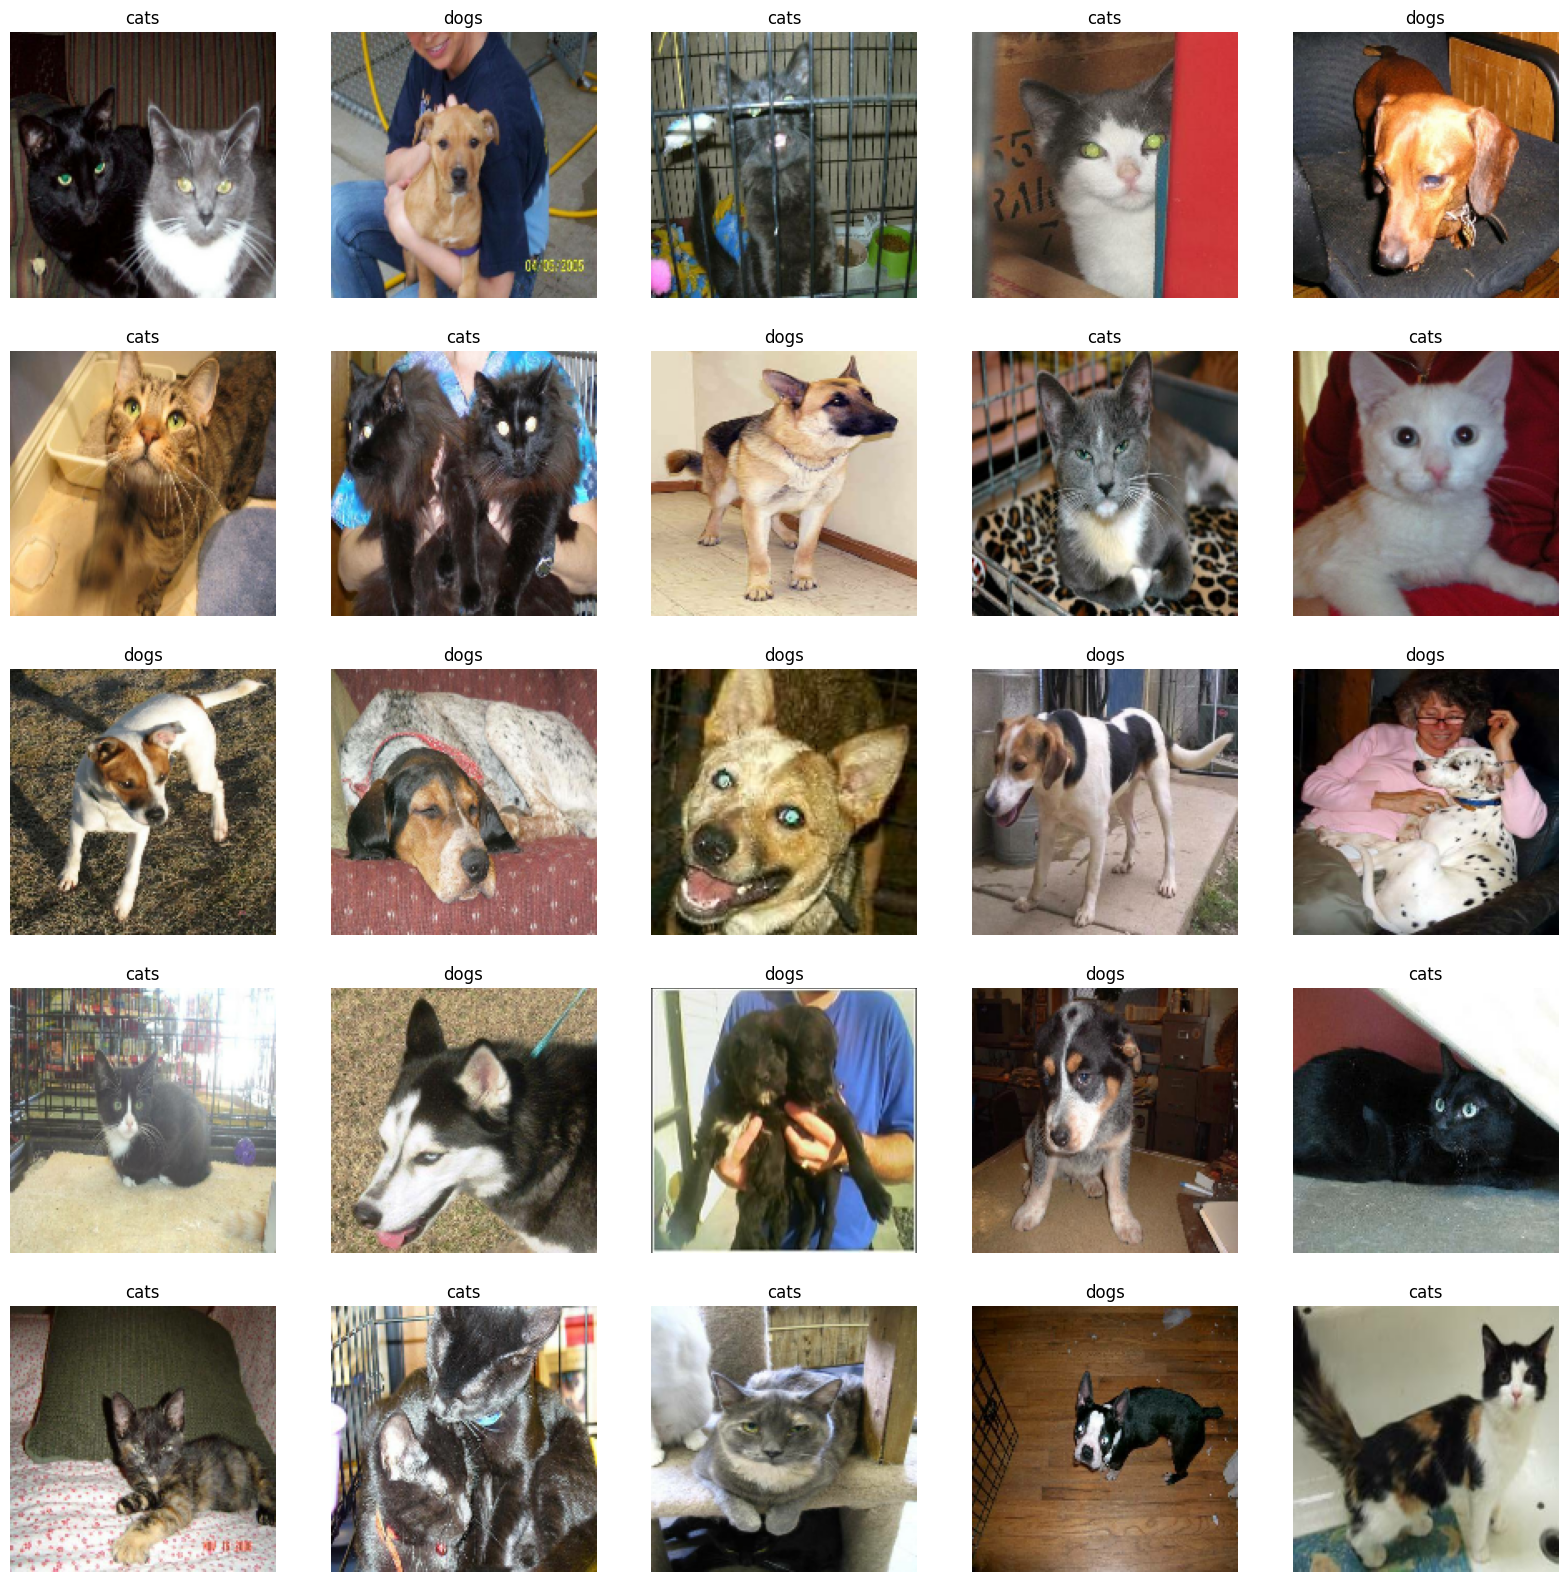

In [11]:
plt.figure(figsize=(20, 20))
for images, labels in train_dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [14]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

first image shape: (160, 160, 3)
Expaned dims of first image:   (1, 160, 160, 3)


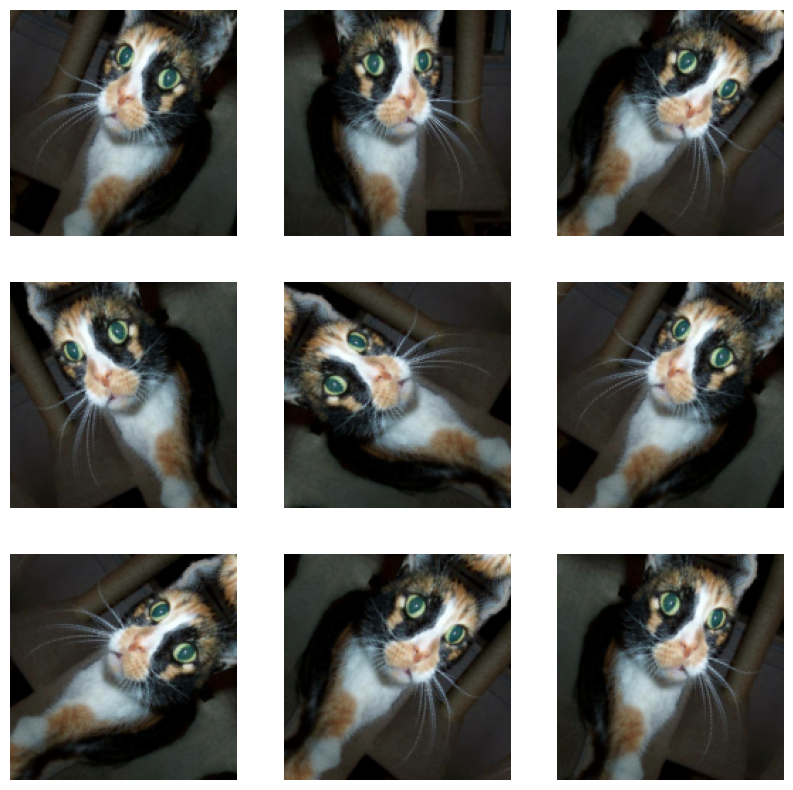

In [15]:
plt.figure(figsize=(10, 10))
for image, label in train_dataset.take(1):
    first_image = image[0]
    print(f'first image shape: {first_image.shape}')
    expaned_dims_first_image =  tf.expand_dims(first_image, 0)
    print(f'Expaned dims of first image:   {expaned_dims_first_image.shape}')

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        augmented_image=data_augmentation(expaned_dims_first_image)

        #rescale augmented_image
        augmented_image = augmented_image[0] / 255
        plt.imshow(augmented_image)
        plt.axis('off')

In [16]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input

<function keras.src.applications.mobilenet_v2.preprocess_input(x, data_format=None)>

In [17]:
IMG_SIZE

(160, 160)

In [18]:
IMG_SHAPE = IMG_SIZE + (3,)
IMG_SHAPE

(160, 160, 3)

In [19]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model

9406464/9406464 [==============================] - 1s 0us/step


In [20]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [21]:
base_model.trainable = False


In [22]:
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [23]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [24]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [25]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model

In [26]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [28]:
len(model.trainable_variables)


2

In [29]:
loss0, accuracy0 = model.evaluate(validation_dataset)


26/26 [==============================] - 18s 582ms/step - loss: 0.8884 - accuracy: 0.3985


In [30]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.89
initial accuracy: 0.40


In [31]:
EPOCHS = 10
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 66s 997ms/step - loss: 0.3364 - accuracy: 0.8280 - val_loss: 0.1059 - val_accuracy: 0.9678
Epoch 2/10
63/63 [==============================] - 61s 963ms/step - loss: 0.1690 - accuracy: 0.9250 - val_loss: 0.0799 - val_accuracy: 0.9777
Epoch 3/10
63/63 [==============================] - 67s 1s/step - loss: 0.1459 - accuracy: 0.9390 - val_loss: 0.0651 - val_accuracy: 0.9802
Epoch 4/10
63/63 [==============================] - 60s 946ms/step - loss: 0.1279 - accuracy: 0.9470 - val_loss: 0.0593 - val_accuracy: 0.9814
Epoch 5/10
63/63 [==============================] - 59s 939ms/step - loss: 0.1313 - accuracy: 0.9455 - val_loss: 0.0634 - val_accuracy: 0.9839
Epoch 6/10
63/63 [==============================] - 59s 940ms/step - loss: 0.1215 - accuracy: 0.9485 - val_loss: 0.0561 - val_accuracy: 0.9851
Epoch 7/10
63/63 [==============================] - 61s 974ms/step - loss: 0.1179 - accuracy: 0.9500 - val_loss: 0.0514 - val_accuracy: 0.9864
Ep

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

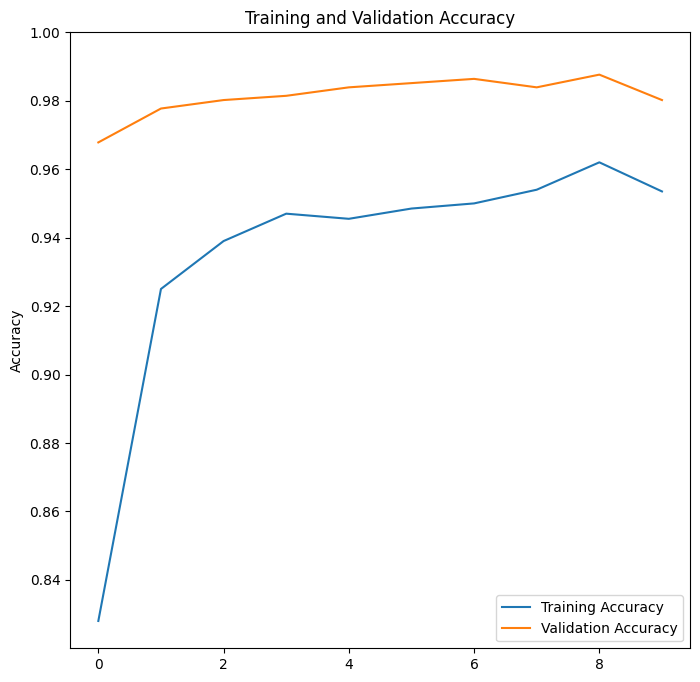

In [33]:
plt.figure(figsize=(8, 8))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()

In [41]:
loss, accuracy = model.evaluate(test_dataset)


6/6 [==============================] - 8s 1s/step - loss: 0.0447 - accuracy: 0.9792


In [42]:
print('Test loss :', loss)
print('Test accuracy :', accuracy)

Test loss : 0.04470089077949524
Test accuracy : 0.9791666865348816


In [43]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
print(predictions)

[  6.7198024   -2.422853     5.4589543    2.3400838    1.3836192
   6.1535983    5.073777     6.4049764   -4.963882     4.323878
  -4.7154913    0.16526553  -9.334413    -9.235895    -7.725892
  -8.17554     -8.036464    -8.580661    -8.18918     -5.3140798
  -0.58164823   2.8242428   -9.477761    -7.862674    -7.4819613
  -6.0870805    6.8774714    4.451182   -10.1496105    3.1177673
  -6.6870637    5.954576  ]


In [44]:
# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

Predictions:
 [1 0 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1]
Labels:
 [1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1]


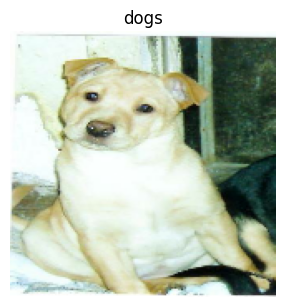

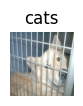

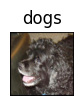

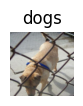

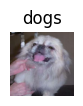

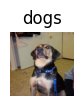

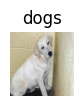

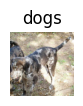

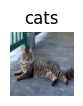

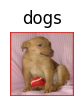

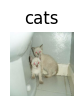

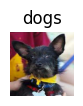

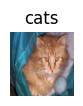

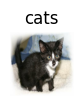

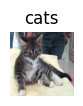

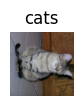

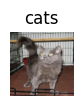

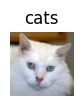

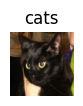

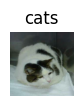

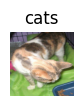

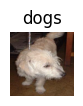

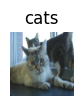

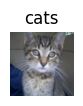

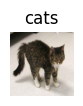

In [45]:
plt.figure(figsize=(20, 20))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")
    plt.show()